## Setup

In [1]:
]activate ..

 Activating environment at `~/Developer/GenWorldModels.jl/examples/audio/Project.toml`


In [2]:
include("main.jl")

Main.AudioInference

In [3]:
using .AudioInference: gammatonegram, AudioSource
using .AudioInference
AI = AudioInference

Main.AudioInference

In [4]:
trr = tones_with_noise(10.); nothing

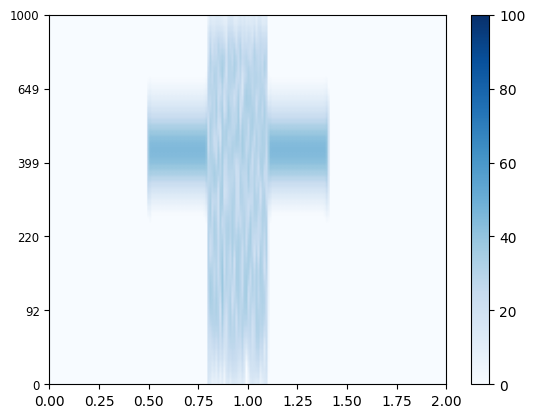

PyObject <matplotlib.colorbar.Colorbar object at 0x7f7b6afe68b0>

In [5]:
vis_and_write_wave(trr, "trr.wav")

In [6]:
using Dates

In [7]:
using PyPlot

In [8]:
include("worldmodel/inference2.jl")

## Functions For Likelihood Recording & Graphing

In [9]:
#=
Outputs matrices where each column is a run for one initial trace,
and each row represents the ith iteration of each run.
=#
function get_times_and_likelihoods(initial_trs, run_inf!, iters)
    likelihoods = zeros(Float64, (iters, length(initial_trs)))
    times = zeros(Float64, (iters, length(initial_trs)))
    starttime = Dates.now()
    run_inf!(initial_trs[1], 20, (tr,) -> nothing) # compilation run
    for (i, initial_tr) in enumerate(initial_trs)
        print("Running trial $i...;")
        println(" $(Dates.now() - starttime) ms ellapsed in total")
        (l, t, record!) = AudioInference.get_worldmodel_likelihood_time_tracker_and_recorder()
        run_inf!(initial_tr, iters, record!)
        likelihoods[:, i] = l
        times[:, i] = t
    end
    return (times, likelihoods)
end

get_times_and_likelihoods (generic function with 1 method)

In [10]:
run_specs = Dict(
    :generic => (AudioInference.do_generic_inference, 1),
    :dumb_bd => (AudioInference.do_birth_death_inference, 1.2),
   # :dumb_sm => (AudioInference.do_split_merge_inference, .6),
    :old_smbd => (AudioInference.do_smart_smbd_inference, .7),
    :new_smbd => (drift_smartsmbd_inference, 0.7),
    :new_bd => (drift_smartbd_inference, 0.75)
)
nothing

In [11]:
function perform_runs(run_specs, initial_trs, num_generic_iters)
    times = Dict()
    likelihoods = Dict()
    
    for (label, (inf, num_iters_multiplier)) in run_specs
        n_iters = Int(floor(num_iters_multiplier*num_generic_iters))
        println("Running ", label, " for ", n_iters, " iterations per initial trace.")
        (t, l) = get_times_and_likelihoods(initial_trs, inf, n_iters)
        times[label] = t
        likelihoods[label] = l
    end
    
    return (times, likelihoods)
end

perform_runs (generic function with 1 method)

In [12]:
function plot_avg_times_and_likelihoods(times, likelihoods; POINT_SIZE=3, order=nothing, names=nothing, miny=nothing, maxx=nothing)
    key_itr = order === nothing ? keys(times) : order
    for label in key_itr
        t = times[label]
        l = likelihoods[label]
        avg_t = sum(t, dims=2) / size(t)[2]
        avg_l = sum(l, dims=2) / size(l)[2]
        name = names === nothing ? String(label) : names[label]
        scatter(avg_t, avg_l, label=name, s=POINT_SIZE)
    end
    if miny !== nothing
        ylim(bottom=miny)
    end
    if maxx !== nothing
        xlim(right=maxx)
    end
    xlabel("time (s)")
    ylabel("log likelihood of observed sound given inferred sources")
    title("Predictive log-likelihod of inferred audio sources over time")
    legend(loc="lower right")
end

plot_avg_times_and_likelihoods (generic function with 1 method)

In [13]:
# merges the new times and likelihoods into the running ones (by concatenating to the
# matrix of run data)
# assumes that the same keys are 
function merge_in_runs!(running_times, running_likelihoods, new_times, new_likelihoods)
    for key in keys(running_times)
       running_times[key] = hcat(running_times[key], new_times[key])
       running_likelihoods[key] = hcat(running_likelihoods[key], new_likelihoods[key])
    end
end

merge_in_runs! (generic function with 1 method)

### Fetch serialized data

In [15]:
using Serialization

In [17]:
(rt, rl) = deserialize("illusion_from_0.data")
size(rl[:generic])

(500, 36)

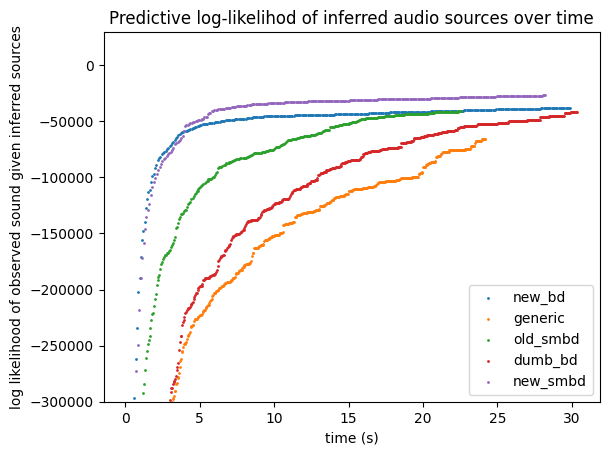

PyObject <matplotlib.legend.Legend object at 0x7f7aab9ddc10>

In [20]:
plot_avg_times_and_likelihoods(rt, rl, POINT_SIZE=1, miny=-300000)

In [49]:
function record_likelihoods!(generate_initial_trs, run_specs, NUM_ITERS;
        filename=nothing,
        running_times=nothing,
        running_likelihoods=nothing,
        num_cycles=1
    )
    @assert num_cycles >= 1
    if running_times === nothing || running_likelihoods === nothing
        @assert running_times === nothing && running_likelihoods === nothing "Cannot provide only 1 of running_times and running_likelihoods"
        initial_trs = generate_initial_trs()
        (running_times, running_likelihoods) = perform_runs(run_specs, initial_trs, NUM_ITERS)
        num_cycles -= 1
    else
       @assert size(running_times[:generic])[1] == NUM_ITERS 
    end
    
    for _=1:(num_cycles)
        if filename !== nothing
            serialize(filename, (times=running_times, likelihoods=running_likelihoods))
        end
        try
            initial_trs = generate_initial_trs()
            (t, l) = perform_runs(run_specs, initial_trs, NUM_ITERS)
            merge_in_runs!(running_times, running_likelihoods, t, l)
        catch e end
    end
    if filename !== nothing
        serialize(filename, (times=running_times, likelihoods=running_likelihoods))
    end
    
    return (running_times, running_likelihoods)
end

record_likelihoods! (generic function with 1 method)

In [30]:
NUM_RUNS_PER_EXPERIMENT = 4

4

In [60]:
## record likelihoods on illusion:
record_likelihoods!(
    () -> [generate_initial_tr(trr, num_sources=0)[1] for _=1:NUM_RUNS_PER_EXPERIMENT],
    run_specs, 500;
    running_times=rt, running_likelihoods=rl, num_cycles=6,
    filename="illusion_from_0_1-4-2021--1-25pm.data"
)

Running new_bd for 375 iterations per initial trace.
Running trial 1...; 2031 milliseconds ms ellapsed in total
Running trial 2...; 34626 milliseconds ms ellapsed in total
Running trial 3...; 66011 milliseconds ms ellapsed in total
Running trial 4...; 95353 milliseconds ms ellapsed in total
Running generic for 500 iterations per initial trace.
Running trial 1...; 434 milliseconds ms ellapsed in total
Running trial 2...; 24943 milliseconds ms ellapsed in total
Running trial 3...; 43704 milliseconds ms ellapsed in total
Running trial 4...; 62992 milliseconds ms ellapsed in total
Running old_smbd for 350 iterations per initial trace.
Running trial 1...; 510 milliseconds ms ellapsed in total
Running trial 2...; 29428 milliseconds ms ellapsed in total
Running trial 3...; 56606 milliseconds ms ellapsed in total
Running trial 4...; 76617 milliseconds ms ellapsed in total
Running dumb_bd for 600 iterations per initial trace.
Running trial 1...; 792 milliseconds ms ellapsed in total
Running tri

Running dumb_bd for 600 iterations per initial trace.
Running trial 1...; 994 milliseconds ms ellapsed in total
Running trial 2...; 28721 milliseconds ms ellapsed in total
Running trial 3...; 63796 milliseconds ms ellapsed in total
Running trial 4...; 88155 milliseconds ms ellapsed in total
Running new_smbd for 350 iterations per initial trace.
Running trial 1...; 1358 milliseconds ms ellapsed in total
Running trial 2...; 28705 milliseconds ms ellapsed in total
Running trial 3...; 58334 milliseconds ms ellapsed in total
Running trial 4...; 80108 milliseconds ms ellapsed in total


(Dict{Any,Any}(:new_bd => [0.066 0.04 … 0.053 0.045; 0.111 0.078 … 0.101 0.111; … ; 30.693 30.843 … 35.338 22.166; 30.773 30.924 … 35.47 22.228],:generic => [0.016 0.025 … 0.045 0.023; 0.027 0.053 … 0.061 0.026; … ; 23.274 26.274 … 20.505 24.477; 23.314 26.316 … 20.54 24.521],:old_smbd => [0.032 0.045 … 0.025 0.024; 0.048 0.062 … 0.079 0.042; … ; 17.248 20.582 … 20.601 22.667; 17.275 20.626 … 20.652 22.72],:dumb_bd => [0.002 0.025 … 0.009 0.012; 0.036 0.035 … 0.011 0.02; … ; 26.354 22.712 … 24.314 22.968; 26.374 22.731 … 24.357 23.003],:new_smbd => [0.07 0.044 … 0.056 0.021; 0.105 0.095 … 0.075 0.073; … ; 29.051 23.098 … 21.719 28.059; 29.108 23.153 … 21.771 28.118]), Dict{Any,Any}(:new_bd => [-1.0286297748460383e6 -630702.7062498743 … -648127.7014363 -1.085287791218141e6; -431316.0911301264 -628124.6403972467 … -311006.28165321134 -1.0682729614235964e6; … ; -39689.39787423876 -37939.862836583285 … -42368.77207316552 -29307.20877971539; -39689.35235322608 -37939.48235499651 … -42368.77

In [59]:
size(rl[:generic])

(500, 48)

In [58]:
deserialize("illusion_from_0_1-4-2021--7-53am.data").times[:generic] |> size

(500, 48)

In [55]:
## record likelihoods on synthetic:
synth_t, synth_l = record_likelihoods!(
    () -> [generate_initial_tr(
                generate(AI.generate_scene, AI.args, choicemap((:kernel => :n_tones, 3)))[1],
                num_sources=0
            )[1]
        for _=1:NUM_RUNS_PER_EXPERIMENT
        ],
    run_specs, 500; running_times=synth_t, running_likelihoods=synth_l,
    num_cycles=4,
    filename="synthetic_from_0_1-4-2021--9-45am.data"
)

Running new_bd for 375 iterations per initial trace.
Running trial 1...; 1242 milliseconds ms ellapsed in total
Running trial 2...; 32430 milliseconds ms ellapsed in total
Running trial 3...; 82634 milliseconds ms ellapsed in total
Running trial 4...; 122497 milliseconds ms ellapsed in total
Running generic for 500 iterations per initial trace.
Running trial 1...; 255 milliseconds ms ellapsed in total
Running trial 2...; 24448 milliseconds ms ellapsed in total
Running trial 3...; 65667 milliseconds ms ellapsed in total
Running trial 4...; 97118 milliseconds ms ellapsed in total
Running old_smbd for 350 iterations per initial trace.
Running trial 1...; 864 milliseconds ms ellapsed in total
Running trial 2...; 33044 milliseconds ms ellapsed in total
Running trial 3...; 63085 milliseconds ms ellapsed in total
Running trial 4...; 89639 milliseconds ms ellapsed in total
Running dumb_bd for 600 iterations per initial trace.
Running trial 1...; 694 milliseconds ms ellapsed in total
Running tr

(Dict{Any,Any}(:new_bd => [0.052 0.04 … 0.08 0.046; 0.086 0.045 … 0.215 0.1; … ; 25.176 7.984 … 50.668 35.474; 25.234 8.0 … 50.778 35.556],:generic => [0.009 0.013 … 0.007 0.028; 0.031 0.026 … 0.029 0.04; … ; 16.374 7.144 … 56.46 30.664; 16.395 7.167 … 56.543 30.709],:old_smbd => [0.03 0.015 … 0.036 0.017; 0.045 0.037 … 0.084 0.032; … ; 16.013 2.514 … 30.288 23.002; 16.148 2.519 … 30.36 23.054],:dumb_bd => [0.017 0.011 … 0.007 0.004; 0.021 0.018 … 0.013 0.051; … ; 19.226 10.95 … 58.588 35.415; 19.251 10.99 … 58.672 35.464],:new_smbd => [0.04 0.03 … 0.089 0.057; 0.07 0.039 … 0.151 0.126; … ; 26.871 4.848 … 62.675 31.512; 26.991 4.858 … 62.882 31.649]), Dict{Any,Any}(:new_bd => [-716717.5686700862 -87606.16045495644 … -1.5609779705722043e6 -1.287327807863708e6; -290056.64770631754 -87606.16045495644 … -1.5320867913815645e6 -1.1504705323670115e6; … ; -46915.012805416314 -10820.873142011593 … -16844.872524289156 -13978.602851323245; -46913.243504371356 -10820.873142011593 … -16844.87252428

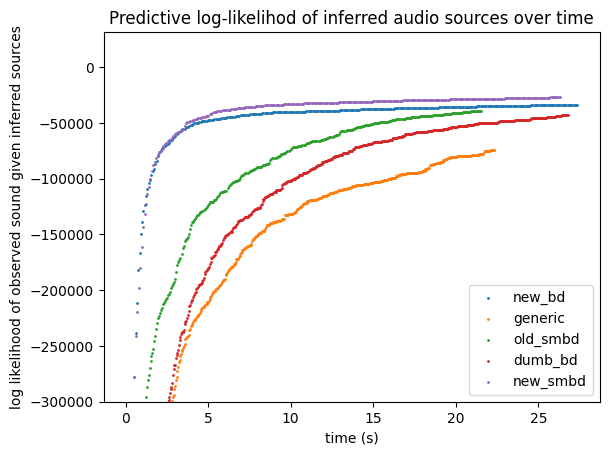

PyObject <matplotlib.legend.Legend object at 0x7f7aab775f10>

In [61]:
plot_avg_times_and_likelihoods(rt, rl, POINT_SIZE=1, miny=-300000)

In [56]:
deserialize("synthetic_from_0_1-4-2021--9-45am.data").likelihoods[:generic] |> size

(500, 56)

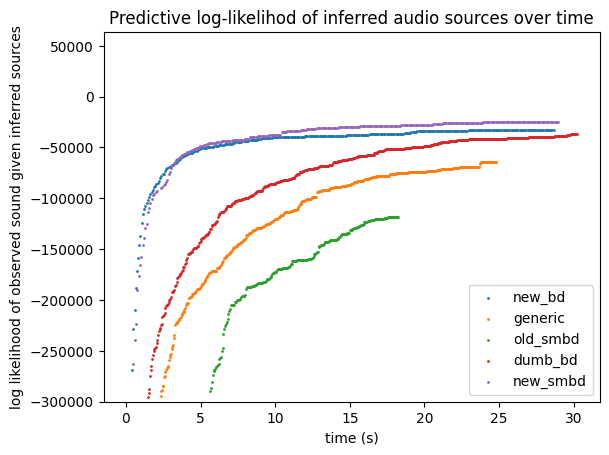

PyObject <matplotlib.legend.Legend object at 0x7f7aab7fef70>

In [57]:
plot_avg_times_and_likelihoods(synth_t, synth_l, POINT_SIZE=1, miny=-300000)

## Record Likelihoods

In [128]:
NUM_RUNS_PER_EXPERIMENT = 4
initial_trs = [generate_initial_tr(trr, num_sources=0)[1] for _=1:NUM_RUNS_PER_EXPERIMENT]
nothing


In [129]:
NUM_ITERS = 500
(t, l) = perform_runs(run_specs, initial_trs, NUM_ITERS)
nothing


Running new_bd for 375 iterations per initial trace.
Running trial 1...; 1297 milliseconds ms ellapsed in total
Running trial 2...; 32072 milliseconds ms ellapsed in total
Running trial 3...; 62998 milliseconds ms ellapsed in total
Running trial 4...; 87572 milliseconds ms ellapsed in total
Running generic for 500 iterations per initial trace.
Running trial 1...; 677 milliseconds ms ellapsed in total
Running trial 2...; 23994 milliseconds ms ellapsed in total
Running trial 3...; 50312 milliseconds ms ellapsed in total
Running trial 4...; 73509 milliseconds ms ellapsed in total
Running old_smbd for 350 iterations per initial trace.
Running trial 1...; 762 milliseconds ms ellapsed in total
Running trial 2...; 18038 milliseconds ms ellapsed in total
Running trial 3...; 38666 milliseconds ms ellapsed in total
Running trial 4...; 57816 milliseconds ms ellapsed in total
Running dumb_bd for 600 iterations per initial trace.
Running trial 1...; 739 milliseconds ms ellapsed in total
Running tri

In [130]:
running_times, running_likelihoods = (t, l)
nothing

In [ ]:
NUM_ITERS = 500
for _=1:8
    try
        initial_trs = [generate_initial_tr(trr)[1] for _=1:4]
        (t, l) = perform_runs(run_specs, initial_trs, NUM_ITERS)
        merge_in_runs!(running_times, running_likelihoods, t, l)
    catch e
        continue;
    end
end

Running new_bd for 375 iterations per initial trace.
Running trial 1...; 1750 milliseconds ms ellapsed in total
Running trial 2...; 32438 milliseconds ms ellapsed in total
Running trial 3...; 68858 milliseconds ms ellapsed in total
Running trial 4...; 102154 milliseconds ms ellapsed in total
Running generic for 500 iterations per initial trace.
Running trial 1...; 375 milliseconds ms ellapsed in total
Running trial 2...; 23849 milliseconds ms ellapsed in total
Running trial 3...; 47599 milliseconds ms ellapsed in total
Running trial 4...; 84256 milliseconds ms ellapsed in total
Running old_smbd for 350 iterations per initial trace.
Running trial 1...; 1416 milliseconds ms ellapsed in total
Running trial 2...; 23510 milliseconds ms ellapsed in total
Running trial 3...; 48366 milliseconds ms ellapsed in total
Running trial 4...; 74784 milliseconds ms ellapsed in total
Running dumb_bd for 600 iterations per initial trace.
Running trial 1...; 947 milliseconds ms ellapsed in total
Running t

In [ ]:
serialize("illusion_from_0_take2.data", (times=running_times, likelihoods=running_likelihoods))

## Plot Likelihoods

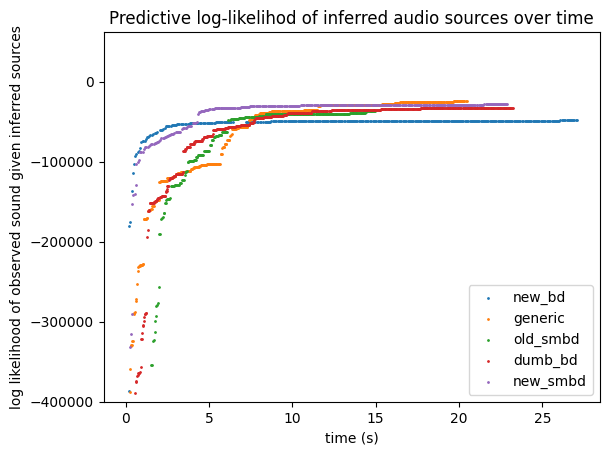

PyObject <matplotlib.legend.Legend object at 0x7fba5bb79580>

In [54]:
plot_avg_times_and_likelihoods(t, l, POINT_SIZE=1, miny=-400000)

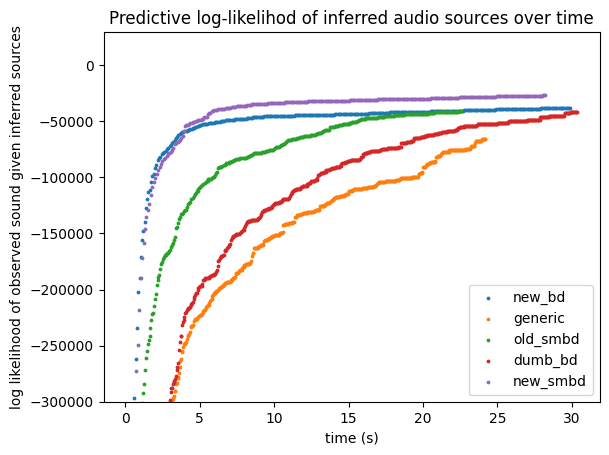

PyObject <matplotlib.legend.Legend object at 0x7fba412f1cd0>

In [132]:
plot_avg_times_and_likelihoods(running_times, running_likelihoods, miny=-300000)

In [39]:
[running_likelihoods[:new_smbd][:, i][100] for i=1:8]

8-element Array{Float64,1}:
 -62613.00295770423
 -55007.042104718355
 -36851.895145785784
 -38032.41264182885
 -49950.4318176188
 -30176.31524658431
 -45351.534364095336
 -29821.291018171614

In [136]:
wanted_tags = [:new_bd, :generic, :dumb_bd, :new_smbd, :old_smbd]
filt_t = Dict(t => running_times[t] for t in wanted_tags)
filt_l = Dict(t => running_likelihoods[t] for t in wanted_tags)

Dict{Symbol,Array{Float64,2}} with 5 entries:
  :new_bd   => [-1.02863e6 -6.30703e5 … -1.05544e6 -1.88531e6; -4.31316e5 -6.28…
  :generic  => [-1.25157e6 -1.25157e6 … -1.1573e6 -9.30902e5; -1.25157e6 -1.251…
  :old_smbd => [-1.0693e6 -1.11493e6 … -9.80212e5 -884799.0; -9.3417e5 -8.8029e…
  :dumb_bd  => [-1.25157e6 -1.25157e6 … -860249.0 -1.31667e6; -1.25157e6 -1.251…
  :new_smbd => [-9.65817e5 -7.95742e5 … -1.31646e6 -1.81127e6; -7.0644e5 -3.561…

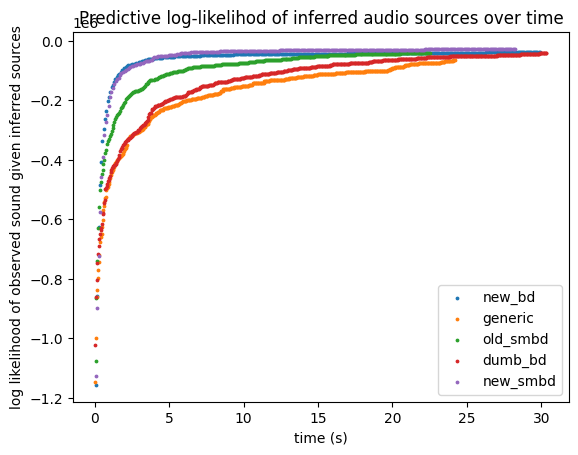

PyObject <matplotlib.legend.Legend object at 0x7fba417be220>

In [137]:
plot_avg_times_and_likelihoods(filt_t, filt_l)

In [67]:
names = Dict(
    :generic => "Ancestral resampling",
    :dumb_bd => "Generic birth/death",
    :new_bd => "Data-driven custom birth/death",
    :new_smbd => "Data-driven birth/death & split-merge"
   # :old_smbd => "AABI Submission best performer"
)

Dict{Symbol,String} with 4 entries:
  :new_bd   => "Data-driven custom birth/death"
  :generic  => "Ancestral resampling"
  :dumb_bd  => "Generic birth/death"
  :new_smbd => "Data-driven birth/death & split-merge"

In [68]:
order = [:generic, :dumb_bd, :new_bd, :new_smbd]#, :old_smbd]

4-element Array{Symbol,1}:
 :generic
 :dumb_bd
 :new_bd
 :new_smbd

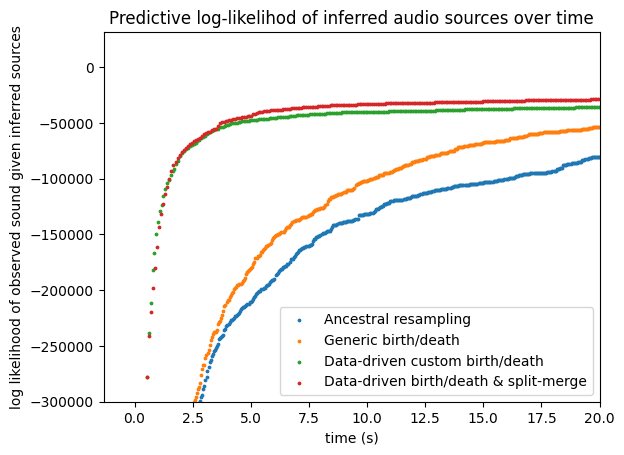

PyObject <matplotlib.legend.Legend object at 0x7f7aab7b1f10>

In [70]:
plot_avg_times_and_likelihoods(rt, rl; order=order, names=names, maxx=20, miny=-300000)

In [65]:
rl[:generic] |> size

(500, 72)

### 

In [147]:
using Serialization
serialize("illusion_from_0.data", (running_times, running_likelihoods))

## Likelihoods on synthetic data

In [149]:
NUM_RUNS = 4
ground_truth_trs = [
    generate(AI.generate_scene, AI.args, choicemap((:kernel => :n_tones, 3)))[1]
    for i=1:NUM_RUNS
]
initial_trs = [
    AI.generate_initial_tr(ground_truth, num_sources=0)[1] for ground_truth in ground_truth_trs
]
nothing

In [150]:
NUM_ITERS = 650

650

In [151]:
(tms, lhs) = perform_runs(run_specs, initial_trs, NUM_ITERS)
nothing

Running new_bd for 487 iterations per initial trace.
Running trial 1...; 904 milliseconds ms ellapsed in total
Running trial 2...; 21502 milliseconds ms ellapsed in total
Running trial 3...; 87580 milliseconds ms ellapsed in total
Running trial 4...; 137083 milliseconds ms ellapsed in total
Running generic for 650 iterations per initial trace.
Running trial 1...; 229 milliseconds ms ellapsed in total
Running trial 2...; 18054 milliseconds ms ellapsed in total
Running trial 3...; 77711 milliseconds ms ellapsed in total
Running trial 4...; 126971 milliseconds ms ellapsed in total
Running old_smbd for 454 iterations per initial trace.
Running trial 1...; 180 milliseconds ms ellapsed in total
Running trial 2...; 10760 milliseconds ms ellapsed in total
Running trial 3...; 59188 milliseconds ms ellapsed in total
Running trial 4...; 98760 milliseconds ms ellapsed in total
Running dumb_bd for 780 iterations per initial trace.
Running trial 1...; 206 milliseconds ms ellapsed in total
Running tr

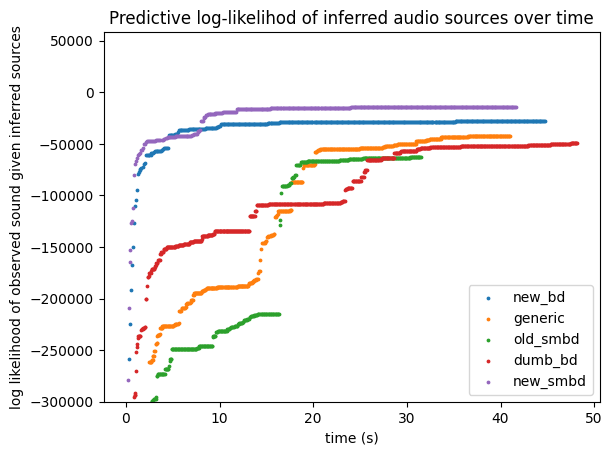

PyObject <matplotlib.legend.Legend object at 0x7fba4f3fb640>

In [152]:
plot_avg_times_and_likelihoods(tms, lhs, miny=-300000)

In [153]:
(running_times2, running_likelihoods2) = (tms, lhs)
nothing 

In [157]:
for _=1:5
    try
        ground_truth_trs = [
            generate(AI.generate_scene, AI.args, choicemap((:kernel => :n_tones, 3)))[1]
            for i=1:NUM_RUNS
        ]
        initial_trs = [
            AI.generate_initial_tr(ground_truth, num_sources=0)[1] for ground_truth in ground_truth_trs
        ]
        (t2, l2) = perform_runs(run_specs, initial_trs, NUM_ITERS)
        merge_in_runs!(running_times2, running_likelihoods2, t2, l2)
    catch e
        continue;
    end
end

Running new_bd for 487 iterations per initial trace.
Running trial 1...; 2786 milliseconds ms ellapsed in total
Running trial 2...; 60464 milliseconds ms ellapsed in total
Running trial 3...; 91563 milliseconds ms ellapsed in total
Running trial 4...; 154970 milliseconds ms ellapsed in total
Running generic for 650 iterations per initial trace.
Running trial 1...; 1167 milliseconds ms ellapsed in total
Running trial 2...; 75713 milliseconds ms ellapsed in total
Running trial 3...; 97529 milliseconds ms ellapsed in total
Running trial 4...; 168603 milliseconds ms ellapsed in total
Running old_smbd for 454 iterations per initial trace.
Running trial 1...; 2084 milliseconds ms ellapsed in total
Running trial 2...; 58803 milliseconds ms ellapsed in total
Running trial 3...; 75612 milliseconds ms ellapsed in total
Running trial 4...; 105386 milliseconds ms ellapsed in total
Running dumb_bd for 780 iterations per initial trace.
Running trial 1...; 956 milliseconds ms ellapsed in total
Runnin

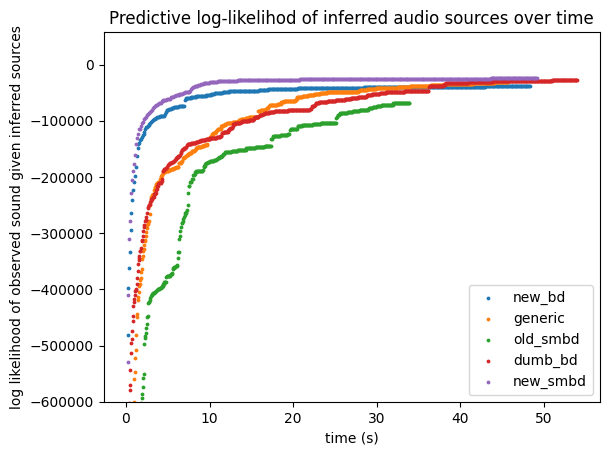

PyObject <matplotlib.legend.Legend object at 0x7fba3fdd98b0>

In [158]:
plot_avg_times_and_likelihoods(running_times2, running_likelihoods2, miny=-600000)

In [ ]:
serialize("synthetic_from_prior_from_0.data", (times = running_times2, likelihoods = running_likelihoods2))

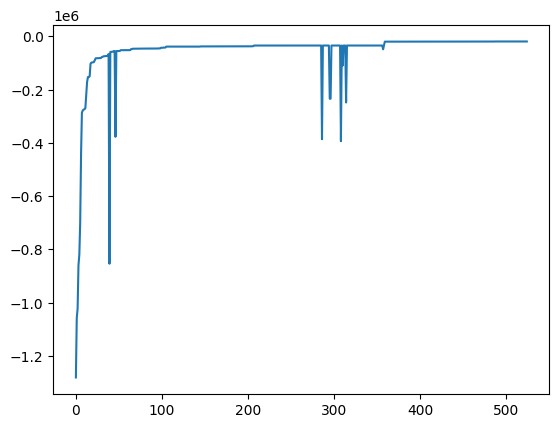

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f13e0695160>

In [79]:
plot(sum(running_likelihoods[:new_smbd][:,8:8], dims=2))

In [81]:
]add Serialize

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%


LoadError: The following package names could not be resolved:
 * Serialize (not found in project, manifest or registry)


In [82]:
using Serialization

In [83]:
serialize("runs_on_audio_illusion.data", (times=running_times, likelihoods=running_likelihoods))

In [84]:
serialize("runs_on_samples_from_prior.data", (times=running_times2, likelihoods=running_likelihoods2))

In [85]:
x = deserialize("runs_on_audio_illusion.data")

(times = Dict{Any,Any}(:new_bd => [0.056 0.062 … 0.148 0.044; 0.105 0.119 … 0.217 0.11; … ; 30.551 44.586 … 36.279 50.009; 30.601 44.645 … 36.331 50.101],:generic => [0.026 0.026 … 0.066 0.015; 0.035 0.032 … 0.079 0.016; … ; 34.419 34.761 … 30.649 38.359; 34.456 34.801 … 30.665 38.401],:old_smbd => [0.036 0.032 … 0.126 0.018; 0.067 0.067 … 0.207 0.066; … ; 27.406 30.891 … 29.566 31.588; 27.455 30.965 … 29.619 31.649],:dumb_bd => [0.011 0.009 … 0.07 0.011; 0.018 0.024 … 0.182 0.016; … ; 31.985 45.217 … 48.073 48.207; 32.019 45.257 … 48.155 48.249],:new_smbd => [0.066 0.026 … 0.122 0.044; 0.103 0.06 … 0.312 0.098; … ; 45.551 39.41 … 58.244 46.058; 45.634 39.494 … 58.336 46.153]), likelihoods = Dict{Any,Any}(:new_bd => [-688062.8424342624 -963853.3389194949 … -1.549051005785353e6 -749944.0731207504; -460249.5862133258 -694244.6291756498 … -1.0995275697531796e6 -260688.34687333717; … ; -14103.824797653027 -27409.76704197369 … -17405.435776213424 -18909.437764544808; -14103.824797653027 -27

## Functions for time vs count recording

In [130]:
function get_worldmodel_count_likelihood_time_tracker_and_recorder()
    counts = Int[]
    times = Float64[]
    starttime = Dates.now()
    function record_worldmodel_iter!(tr)
        push!(counts, tr[:kernel => :n_tones])
        push!(times, Dates.value(Dates.now() - starttime)/1000)
    end
    return (counts, times, record_worldmodel_iter!)
end

get_worldmodel_count_likelihood_time_tracker_and_recorder (generic function with 1 method)

In [144]:
#=
Outputs matrices where each column is a run for one initial trace,
and each row represents the ith iteration of each run.
=#
function get_times_and_counts(initial_trs, run_inf!, iters)
    counts = zeros(Int, (iters, length(initial_trs)))
    times = zeros(Float64, (iters, length(initial_trs)))
    starttime = Dates.now()
    run_inf!(initial_trs[1], 20, (tr,) -> nothing) # compilation run
    for (i, initial_tr) in enumerate(initial_trs)
        print("Running trial $i...;")
        println(" $(Dates.now() - starttime) ms ellapsed in total")
        (c, t, record!) = get_worldmodel_count_likelihood_time_tracker_and_recorder()
        run_inf!(initial_tr, iters, record!)
        counts[:, i] = c
        times[:, i] = t
    end
    return (times, counts)
end

get_times_and_counts (generic function with 1 method)

In [145]:
function perform_count_runs(run_specs, initial_trs, num_generic_iters)
    times = Dict()
    counts = Dict()
    
    for (label, (inf, num_iters_multiplier)) in run_specs
        n_iters = Int(floor(num_iters_multiplier*num_generic_iters))
        println("Running ", label, " for ", n_iters, " iterations per initial trace.")
        (t, c) = get_times_and_counts(initial_trs, inf, n_iters)
        times[label] = t
        counts[label] = c
    end
    
    return (times, counts)
end

perform_count_runs (generic function with 1 method)

## Record time vs counts

In [204]:
filtered_specs = Dict(i => run_specs[i] for i in (:generic, :smart_bd, :dumb_bd, :smart_smbd))

Dict{Symbol,Tuple{Function,Real}} with 4 entries:
  :smart_bd   => (do_smart_bd_inference, 1)
  :generic    => (do_generic_inference, 1)
  :dumb_bd    => (do_birth_death_inference, 1)
  :smart_smbd => (do_smart_smbd_inference, 0.9)

In [205]:
initial_trs = [AudioInference.generate_initial_tr(trr)[1] for _=1:200]
(t, c) = perform_count_runs(filtered_specs, initial_trs, 20)

Running smart_bd for 20 iterations per initial trace.
Running trial 1...; 8442 milliseconds ms ellapsed in total
Running trial 2...; 11323 milliseconds ms ellapsed in total
Running trial 3...; 13827 milliseconds ms ellapsed in total
Running trial 4...; 16258 milliseconds ms ellapsed in total
Running trial 5...; 17310 milliseconds ms ellapsed in total
Running trial 6...; 19073 milliseconds ms ellapsed in total
Running trial 7...; 20662 milliseconds ms ellapsed in total
Running trial 8...; 21551 milliseconds ms ellapsed in total
Running trial 9...; 24108 milliseconds ms ellapsed in total
Running trial 10...; 24585 milliseconds ms ellapsed in total
Running trial 11...; 27187 milliseconds ms ellapsed in total
Running trial 12...; 28947 milliseconds ms ellapsed in total
Running trial 13...; 31679 milliseconds ms ellapsed in total
Running trial 14...; 32272 milliseconds ms ellapsed in total
Running trial 15...; 33164 milliseconds ms ellapsed in total
Running trial 16...; 34797 milliseconds m

Running trial 133...; 207380 milliseconds ms ellapsed in total
Running trial 134...; 208685 milliseconds ms ellapsed in total
Running trial 135...; 210741 milliseconds ms ellapsed in total
Running trial 136...; 212168 milliseconds ms ellapsed in total
Running trial 137...; 213105 milliseconds ms ellapsed in total
Running trial 138...; 214822 milliseconds ms ellapsed in total
Running trial 139...; 216245 milliseconds ms ellapsed in total
Running trial 140...; 217092 milliseconds ms ellapsed in total
Running trial 141...; 218508 milliseconds ms ellapsed in total
Running trial 142...; 219210 milliseconds ms ellapsed in total
Running trial 143...; 222037 milliseconds ms ellapsed in total
Running trial 144...; 223641 milliseconds ms ellapsed in total
Running trial 145...; 224340 milliseconds ms ellapsed in total
Running trial 146...; 225808 milliseconds ms ellapsed in total
Running trial 147...; 227720 milliseconds ms ellapsed in total
Running trial 148...; 229142 milliseconds ms ellapsed i

Running trial 65...; 69565 milliseconds ms ellapsed in total
Running trial 66...; 70852 milliseconds ms ellapsed in total
Running trial 67...; 71506 milliseconds ms ellapsed in total
Running trial 68...; 73216 milliseconds ms ellapsed in total
Running trial 69...; 73862 milliseconds ms ellapsed in total
Running trial 70...; 74452 milliseconds ms ellapsed in total
Running trial 71...; 75075 milliseconds ms ellapsed in total
Running trial 72...; 76046 milliseconds ms ellapsed in total
Running trial 73...; 76775 milliseconds ms ellapsed in total
Running trial 74...; 78268 milliseconds ms ellapsed in total
Running trial 75...; 79266 milliseconds ms ellapsed in total
Running trial 76...; 79825 milliseconds ms ellapsed in total
Running trial 77...; 80816 milliseconds ms ellapsed in total
Running trial 78...; 81385 milliseconds ms ellapsed in total
Running trial 79...; 81913 milliseconds ms ellapsed in total
Running trial 80...; 82587 milliseconds ms ellapsed in total
Running trial 81...; 832

Running trial 129...; 139789 milliseconds ms ellapsed in total
Running trial 130...; 140427 milliseconds ms ellapsed in total
Running trial 131...; 141094 milliseconds ms ellapsed in total
Running trial 132...; 141708 milliseconds ms ellapsed in total
Running trial 133...; 143358 milliseconds ms ellapsed in total
Running trial 134...; 144487 milliseconds ms ellapsed in total
Running trial 135...; 146591 milliseconds ms ellapsed in total
Running trial 136...; 147633 milliseconds ms ellapsed in total
Running trial 137...; 148383 milliseconds ms ellapsed in total
Running trial 138...; 149108 milliseconds ms ellapsed in total
Running trial 139...; 149976 milliseconds ms ellapsed in total
Running trial 140...; 150755 milliseconds ms ellapsed in total
Running trial 141...; 151554 milliseconds ms ellapsed in total
Running trial 142...; 152698 milliseconds ms ellapsed in total
Running trial 143...; 154735 milliseconds ms ellapsed in total
Running trial 144...; 155976 milliseconds ms ellapsed i

Running trial 191...; 272840 milliseconds ms ellapsed in total
Running trial 192...; 273857 milliseconds ms ellapsed in total
Running trial 193...; 275004 milliseconds ms ellapsed in total
Running trial 194...; 275702 milliseconds ms ellapsed in total
Running trial 195...; 277058 milliseconds ms ellapsed in total
Running trial 196...; 278716 milliseconds ms ellapsed in total
Running trial 197...; 281390 milliseconds ms ellapsed in total
Running trial 198...; 281744 milliseconds ms ellapsed in total
Running trial 199...; 282356 milliseconds ms ellapsed in total
Running trial 200...; 284197 milliseconds ms ellapsed in total


(Dict{Any,Any}(:smart_bd => [0.339 0.121 … 0.094 0.13; 0.709 0.202 … 0.307 0.235; … ; 2.778 2.431 … 2.091 2.197; 2.879 2.503 … 2.304 2.276],:generic => [0.135 0.241 … 0.089 0.111; 0.152 0.263 … 0.158 0.173; … ; 0.641 0.765 … 1.691 1.432; 0.667 0.788 … 1.741 1.508],:dumb_bd => [0.099 0.11 … 0.081 0.108; 0.16 0.18 … 0.158 0.195; … ; 1.447 1.509 … 1.701 1.643; 1.481 1.564 … 1.801 1.715],:smart_smbd => [0.087 0.14 … 0.107 0.115; 0.194 0.257 … 0.272 0.254; … ; 1.888 2.243 … 1.744 2.188; 1.976 2.423 … 1.839 2.327]), Dict{Any,Any}(:smart_bd => [7 9 … 9 9; 7 9 … 9 8; … ; 9 8 … 10 7; 9 8 … 10 7],:generic => [2 2 … 9 6; 2 2 … 9 6; … ; 2 2 … 7 6; 2 2 … 7 6],:dumb_bd => [7 9 … 9 8; 8 9 … 9 8; … ; 4 6 … 8 7; 4 6 … 8 7],:smart_smbd => [7 10 … 9 10; 7 10 … 9 10; … ; 8 10 … 9 9; 8 10 … 9 9]))

In [186]:
# counts = matrix, where each column has counts at each iter
# times = matrix, where each column has time at which each iter occurred
function get_count_to_time(times, counts)
    counts_to_time = [Set() for _=1:maximum(counts)]
    num_runs = size(times)[2]
    for run=1:num_runs
        t = times[:, run]
        c = counts[:, run]
        for i=1:length(t)
            i == 1 && continue
            Δt = t[i] - t[i-1]
            push!(counts_to_time[c[i]], Δt)
        end
    end
    return counts_to_time
end

get_count_to_time (generic function with 1 method)

In [187]:
label = :smart_smbd_drift
ctot = get_count_to_time(t[label], c[label])

4-element Array{Set{Any},1}:
 Set([0.01200000000000001, 0.03, 0.013999999999999957, 0.059, 0.02400000000000002, 0.034, 0.017000000000000015, 0.06, 0.021999999999999992])
 Set([0.04299999999999998, 0.023999999999999966, 0.02100000000000002, 0.06099999999999997, 0.025000000000000022, 0.044999999999999984, 0.02200000000000002, 0.04300000000000004, 0.103, 0.026999999999999996  …  0.03600000000000003, 0.01899999999999996, 0.031000000000000007, 0.027000000000000024, 0.031000000000000028, 0.05399999999999999, 0.09499999999999997, 0.029999999999999916, 0.03399999999999999, 0.026000000000000023])
 Set([0.032999999999999974, 0.02099999999999999, 0.07599999999999998, 0.038000000000000034, 0.028000000000000004, 0.034999999999999976, 0.01899999999999999, 0.017999999999999988, 0.019000000000000003, 0.021000000000000005, 0.04000000000000001, 0.024999999999999994, 0.03700000000000003, 0.034, 0.018000000000000016, 0.04999999999999999, 0.017, 0.08000000000000002, 0.027])
 Set([0.03199999999999997, 0.023

In [188]:
reduce(+, ctot[1]; init=0.)

0.272

In [207]:
function plot_count_to_avg_time(times, counts; POINT_SIZE=5, order=nothing, names=nothing)
    key_itr = order === nothing ? keys(times) : order
    for label in key_itr
        t = times[label]
        c = counts[label]
        count_to_time = get_count_to_time(t, c)
        count_to_avg_time = map(v -> reduce(+, v; init=0.)/length(v), count_to_time)
        plot(1:length(count_to_avg_time), count_to_avg_time, label=label)
    end
     ylabel("time (s) for inference pass")
     xlabel("num sources in inferred trace")
    title("Runtime/iter for different numbers of inferred sources")
    legend(loc="lower right")
end

plot_count_to_avg_time (generic function with 1 method)

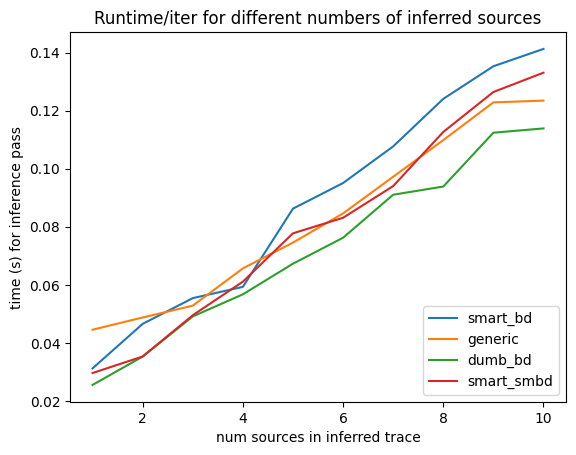

PyObject <matplotlib.legend.Legend object at 0x7fa809c329d0>

In [208]:
plot_count_to_avg_time(t, c)

# Timing individual kernel runs vs "active set"

Here, I want to time how long it takes to run each kernel in traces with different numbers of components.

In [122]:
names = Dict(
    :generic => "Ancestral resampling",
    :dumb_bd => "Generic birth/death",
    :smart_bd => "Data-driven custom birth/death",
    :smart_smbd => "Data-driven birth/death & split-merge"
)

Dict{Symbol,String} with 4 entries:
  :smart_bd   => "Data-driven custom birth/death"
  :generic    => "Ancestral resampling"
  :dumb_bd    => "Generic birth/death"
  :smart_smbd => "Data-driven birth/death & split-merge"

In [123]:
order = [:generic, :dumb_bd, :smart_bd, :smart_smbd]

4-element Array{Symbol,1}:
 :generic
 :dumb_bd
 :smart_bd
 :smart_smbd

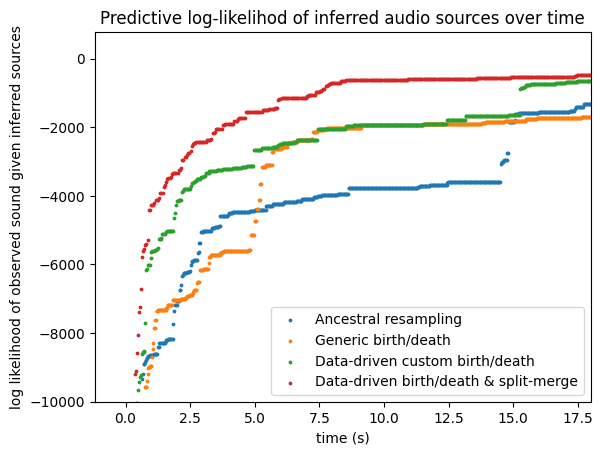

PyObject <matplotlib.legend.Legend object at 0x7fa82b3fe910>

In [124]:
plot_avg_times_and_likelihoods(filt_t, filt_l; order=order, names=names, maxx=18, miny=-10000)

In [101]:
using Serialization

In [102]:
serialize("save.txt", running_times)

In [73]:
initial_trs = [generate_initial_tr(trr)[1] for _=1:2]
(t, l) = perform_runs(run_specs, initial_trs, 10)
nothing

Running smart_smbd_drift for 14 iterations per initial trace.
Running trial 1...; 778 milliseconds ms ellapsed in total
Running trial 2...; 1187 milliseconds ms ellapsed in total
Running smart_bd for 10 iterations per initial trace.
Running trial 1...; 1175 milliseconds ms ellapsed in total
Running trial 2...; 1686 milliseconds ms ellapsed in total
Running dumb_bd_drift for 20 iterations per initial trace.
Running trial 1...; 462 milliseconds ms ellapsed in total
Running trial 2...; 811 milliseconds ms ellapsed in total
Running generic for 10 iterations per initial trace.
Running trial 1...; 992 milliseconds ms ellapsed in total
Running trial 2...; 1651 milliseconds ms ellapsed in total
Running sumb_sm for 6 iterations per initial trace.
Running trial 1...; 1082 milliseconds ms ellapsed in total
Running trial 2...; 1268 milliseconds ms ellapsed in total
Running dumb_bd for 10 iterations per initial trace.
Running trial 1...; 764 milliseconds ms ellapsed in total
Running trial 2...; 124

(Dict{Any,Any}(:smart_smbd_drift => [0.057 0.034; 0.087 0.063; … ; 0.38 0.262; 0.409 0.282],:smart_bd => [0.06 0.043; 0.105 0.078; … ; 0.461 0.38; 0.508 0.505],:dumb_bd_drift => [0.054 0.038; 0.107 0.063; … ; 0.342 0.205; 0.347 0.211],:generic => [0.057 0.037; 0.12 0.069; … ; 0.617 0.342; 0.657 0.365],:sumb_sm => [0.041 0.066; 0.07 0.163; … ; 0.126 0.358; 0.185 0.399],:dumb_bd => [0.072 0.041; 0.106 0.076; … ; 0.433 0.23; 0.473 0.253],:smart_smbd => [0.073 0.065; 0.185 0.125; … ; 0.573 0.41; 0.638 0.46],:smart_bd_drift => [0.059 0.034; 0.099 0.059; … ; 0.532 0.384; 0.559 0.407]), Dict{Any,Any}(:smart_smbd_drift => [-2.1307801340100784e6 -1.396451908363496e6; -1.9061991578764434e6 -1.396451908363496e6; … ; -1.0310230419878433e6 -991138.8426096879; -970370.2847237488 -910472.9268416286],:smart_bd => [-1.6470581440844033e6 -871398.4706193351; -730629.8165339689 -802775.9871996215; … ; -530856.5244940252 -425806.4910383496; -476166.67867628887 -406283.48107621],:dumb_bd_drift => [-2.529917

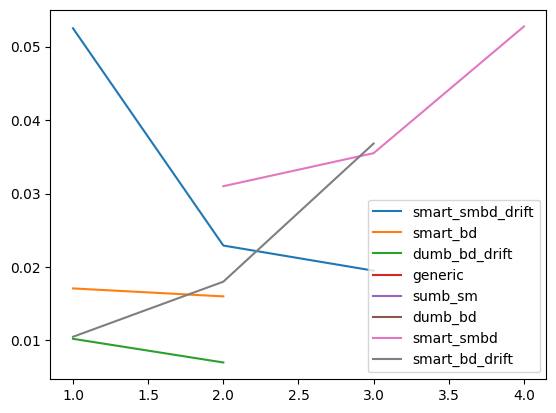

PyObject <matplotlib.legend.Legend object at 0x7fa809b8ba00>

In [178]:
plot_count_to_avg_time(t, c)

In [79]:
rt, rl = t, l

(Dict{Any,Any}(:smart_smbd_drift => [0.071 0.034; 0.12 0.053; … ; 0.389 0.466; 0.415 0.491],:smart_bd => [0.098 0.03; 0.165 0.068; … ; 0.461 0.336; 0.489 0.405],:dumb_bd_drift => [0.066 0.023; 0.103 0.035; … ; 0.284 0.285; 0.29 0.296],:generic => [0.106 0.019; 0.15 0.027; … ; 0.266 0.124; 0.29 0.132],:sumb_sm => [0.08 0.039; 0.15 0.082; … ; 0.365 0.348; 0.422 0.412],:dumb_bd => [0.063 0.036; 0.109 0.06; … ; 0.38 0.394; 0.417 0.43],:smart_smbd => [0.066 0.047; 0.116 0.089; … ; 0.441 0.255; 0.491 0.276],:smart_bd_drift => [0.063 0.029; 0.111 0.049; … ; 0.728 0.308; 0.756 0.318]), Dict{Any,Any}(:smart_smbd_drift => [-3.216892983009465e6 -2.7896087207850134e6; -2.225879950010791e6 -2.58925382775645e6; … ; -954732.3186893351 -840807.1931002293; -884138.1426321606 -840765.4747862486],:smart_bd => [-974366.9808457704 -1.2762175234359966e6; -916231.5729730739 -871603.0608388134; … ; -641179.525747965 -754664.9525369036; -550894.0781458482 -754664.9525369036],:dumb_bd_drift => [-3.2055732508253

In [76]:
initial_trs = [generate_initial_tr(trr)[1] for _=1:2]
(t, l) = perform_runs(run_specs, initial_trs, 10)

Running smart_smbd_drift for 14 iterations per initial trace.
Running trial 1...; 716 milliseconds ms ellapsed in total
Running trial 2...; 1134 milliseconds ms ellapsed in total
Running smart_bd for 10 iterations per initial trace.
Running trial 1...; 1716 milliseconds ms ellapsed in total
Running trial 2...; 2207 milliseconds ms ellapsed in total
Running dumb_bd_drift for 20 iterations per initial trace.
Running trial 1...; 1427 milliseconds ms ellapsed in total
Running trial 2...; 1718 milliseconds ms ellapsed in total
Running generic for 10 iterations per initial trace.
Running trial 1...; 404 milliseconds ms ellapsed in total
Running trial 2...; 696 milliseconds ms ellapsed in total
Running sumb_sm for 6 iterations per initial trace.
Running trial 1...; 1362 milliseconds ms ellapsed in total
Running trial 2...; 1786 milliseconds ms ellapsed in total
Running dumb_bd for 10 iterations per initial trace.
Running trial 1...; 682 milliseconds ms ellapsed in total
Running trial 2...; 11

(Dict{Any,Any}(:smart_smbd_drift => [0.071 0.034; 0.12 0.053; … ; 0.389 0.466; 0.415 0.491],:smart_bd => [0.098 0.03; 0.165 0.068; … ; 0.461 0.336; 0.489 0.405],:dumb_bd_drift => [0.066 0.023; 0.103 0.035; … ; 0.284 0.285; 0.29 0.296],:generic => [0.106 0.019; 0.15 0.027; … ; 0.266 0.124; 0.29 0.132],:sumb_sm => [0.08 0.039; 0.15 0.082; … ; 0.365 0.348; 0.422 0.412],:dumb_bd => [0.063 0.036; 0.109 0.06; … ; 0.38 0.394; 0.417 0.43],:smart_smbd => [0.066 0.047; 0.116 0.089; … ; 0.441 0.255; 0.491 0.276],:smart_bd_drift => [0.063 0.029; 0.111 0.049; … ; 0.728 0.308; 0.756 0.318]), Dict{Any,Any}(:smart_smbd_drift => [-3.216892983009465e6 -2.7896087207850134e6; -2.225879950010791e6 -2.58925382775645e6; … ; -954732.3186893351 -840807.1931002293; -884138.1426321606 -840765.4747862486],:smart_bd => [-974366.9808457704 -1.2762175234359966e6; -916231.5729730739 -871603.0608388134; … ; -641179.525747965 -754664.9525369036; -550894.0781458482 -754664.9525369036],:dumb_bd_drift => [-3.2055732508253

In [80]:
merge_in_runs!(rt, rl, t, l)

In [83]:
for _=1:2
    initial_trs = [generate_initial_tr(trr)[1] for _=1:2]
    (t, l) = perform_runs(run_specs, initial_trs, 10)
    merge_in_runs!(rt, rl, t, l)
end

Running smart_smbd_drift for 14 iterations per initial trace.
Running trial 1...; 631 milliseconds ms ellapsed in total
Running trial 2...; 1100 milliseconds ms ellapsed in total
Running smart_bd for 10 iterations per initial trace.
Running trial 1...; 452 milliseconds ms ellapsed in total
Running trial 2...; 865 milliseconds ms ellapsed in total
Running dumb_bd_drift for 20 iterations per initial trace.
Running trial 1...; 433 milliseconds ms ellapsed in total
Running trial 2...; 588 milliseconds ms ellapsed in total
Running generic for 10 iterations per initial trace.
Running trial 1...; 575 milliseconds ms ellapsed in total
Running trial 2...; 706 milliseconds ms ellapsed in total
Running sumb_sm for 6 iterations per initial trace.
Running trial 1...; 784 milliseconds ms ellapsed in total
Running trial 2...; 992 milliseconds ms ellapsed in total
Running dumb_bd for 10 iterations per initial trace.
Running trial 1...; 707 milliseconds ms ellapsed in total
Running trial 2...; 862 mill

In [ ]:
(generic_times, generic_likelihoods) = get_avg_likelihoods(initial_trs), AudioInference.do_generic_inference, 180)
plot(generic_times, generic_likelihoods)

In [ ]:
(bd_times, bd_likelihoods) = get_avg_likelihoods(initial_trs, AudioInference.do_birth_death_inference, 200)
plot(bd_times, bd_likelihoods)

In [ ]:
(sm_times, sm_likelihoods) = get_avg_likelihoods(initial_trs, AudioInference.do_split_merge_inference, 100)
plot(sm_times, sm_likelihoods)

In [ ]:
(smart_bd_times, smart_bd_likelihoods) = get_avg_likelihoods(initial_trs, AudioInference.do_split_merge_inference, 100)

In [ ]:
TIME_CAP = 7.0
g_indices = filter(i -> generic_times[i] < TIME_CAP, 1:length(generic_times))
bd_indices = filter(i -> bd_times[i] < TIME_CAP, 1:length(bd_times))
sm_indices = filter(i -> sm_times[i] < TIME_CAP, 1:length(sm_times))
nothing

In [ ]:
POINT_SIZE = 8
scatter(generic_times[g_indices], generic_likelihoods[g_indices], label="generic", s=POINT_SIZE)
scatter(bd_times[bd_indices], bd_likelihoods[bd_indices], label="birth/death", s=POINT_SIZE)
scatter(sm_times[sm_indices], sm_likelihoods[sm_indices], label="split/merge", s=POINT_SIZE)
xlabel("time (s)")
ylabel("log likelihood of observed sound given inferred waves")
title("Quality of inferred waveforms over time")
legend(loc="lower right")

In [ ]:
(generic_times2, generic_likelihoods2) = get_avg_likelihoods(fill(initial_tr,20), AudioInference.do_generic_inference, 540)
plot(generic_times2, generic_likelihoods2)

In [ ]:
(bd_times2, bd_likelihoods2) = get_avg_likelihoods(fill(initial_tr,20), AudioInference.do_birth_death_inference, 600)
plot(bd_times2, bd_likelihoods2)

In [ ]:
(sm_times2, sm_likelihoods2) = get_avg_likelihoods(fill(initial_tr,20), AudioInference.do_split_merge_inference, 400)
plot(sm_times2, sm_likelihoods2)

In [ ]:
TIME_CAP = 30.0
g_indices2 = filter(i -> generic_times2[i] < TIME_CAP, 1:length(generic_times2))
bd_indices2 = filter(i -> bd_times2[i] < TIME_CAP, 1:length(bd_times2))
sm_indices2 = filter(i -> sm_times2[i] < TIME_CAP, 1:length(sm_times2))
nothing

In [ ]:
ax = gca()
ax[:set_ylim]([-400000, 0])
POINT_SIZE = 1
scatter(generic_times2[g_indices2], generic_likelihoods2[g_indices2], label="generic", s=POINT_SIZE)
scatter(bd_times2[bd_indices2], bd_likelihoods2[bd_indices2], label="birth/death", s=POINT_SIZE)
scatter(sm_times2[sm_indices2], sm_likelihoods2[sm_indices2], label="split/merge", s=POINT_SIZE)
xlabel("time (s)")
ylabel("log likelihood of observed sound given inferred waves")
title("Quality of inferred waveforms over time")
legend(loc="lower right")

In [ ]:
function get_avg_likelihoods(initial_trs, run_inf!, iters)
  likelihoods = zeros(Float64, iters)
  times = zeros(Float64, iters)
  starttime = Dates.now()
  run_inf!(initial_tr, 20, (tr,) -> nothing) # compilation run
  for (i, initial_tr) in enumerate(initial_trs)
    print("Running trial $i...;")
    println(" $(Dates.now() - starttime) ms ellapsed in total")
    (l, t, record!) = AudioInference.get_worldmodel_likelihood_time_tracker_and_recorder()
    run_inf!(initial_tr, iters, record!)
    likelihoods += l
    times += t
  end
  likelihoods /= length(initial_trs)
  times /= length(initial_trs)
  return (times, likelihoods)
end

In [ ]:
function get_avg_likelihoods_and_counts(initial_trs, run_inf!, iters)
  likelihoods = zeros(Float64, iters)
  counts = []
  starttime = Dates.now()
  for (i, initial_tr) in enumerate(initial_trs)
    print("Running trial $i...;")
    println(" $(Dates.now() - starttime) ms ellapsed in total")
    (l, record!) = AudioInference.get_worldmodel_likelihood_tracker_and_recorder()
    tr = run_inf!(initial_tr, iters, record!)
    push!(counts, tr[:kernel => :n_tones])
    likelihoods += l
  end
  likelihoods /= length(initial_trs)
  return (likelihoods, counts)
end

In [ ]:
(l, c) = get_avg_likelihoods_and_counts(fill(initial_tr,2), AudioInference.do_birth_death_inference, 600)
c

In [ ]:
(l, c) = get_avg_likelihoods_and_counts(fill(initial_tr,2), AudioInference.do_split_merge_inference, 600)
c

In [ ]:
using Pkg; Pkg.add("ProfileView")

In [ ]:
using Profile; using ProfileView;

In [ ]:
@profile get_avg_likelihoods_and_counts(fill(initial_tr,5), AudioInference.do_split_merge_inference, 600)

In [ ]:
ProfileView.view()

In [ ]:
function plot_gtg(gtg, duration, audio_sr, vmin, vmax;colors="Blues",plot_colorbar=false)
    
    max_freq=audio_sr/2
    imshow(gtg, cmap=colors, origin="lower", extent=(0, duration, 0, max_freq),vmin=vmin, vmax=vmax, aspect=1/1300)
    locs, labels = yticks();
    lowlim = AudioInference.freq_to_ERB(1.)
    hilim = AudioInference.freq_to_ERB(max_freq)
    fs = Int.(floor.(AudioInference.ERB_to_freq(range(lowlim, stop=hilim, length=length(locs)))))
    setp(gca().set_yticklabels(fs), fontsize="small")
    if plot_colorbar
        plt.colorbar()
    end
end

In [ ]:
function vis(tr)
    duration, _, sr, = AudioInference.get_args(tr)
    gram, scene_wave, = AudioInference.get_retval(tr)
  #  wavwrite(scene_wave/maximum(abs.(scene_wave)), title, Fs=sr)
 # display(gram)
    plot_gtg(gram, duration, sr, 0, 100)
end

In [ ]:
trr = tones_with_noise(10.); nothing

In [ ]:
vis(trr)

In [ ]:
tr = AudioInference.do_birth_death_inference(initial_tr, 500, (tr,) -> ())

In [ ]:
vis(tr)